#### This program takes in a preprocessed excel file *without* standard deviation subtraction with 2 sets of data (such as AD vs WT). The output of this program are violin plots and stripplots that show the differences in quantile values and range of values between the proteins of these two sets of data. The outliers within the data will be processed and removed if and only if they are deemed to be artificial

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import statistics
import math
%matplotlib inline

In [72]:
# Where the file is located
input_path = 'C:/Users/jesse/OneDrive/Documents/Multiplex Lab/Data/NewADvsWT/ADvsWT sample combined.xlsx'

data = pd.read_excel(input_path, sheet_name = "Single cells")
bg = pd.read_excel(input_path, sheet_name = "Zero cells")
bg = bg.iloc[:, 1:len(bg.columns)]

In [47]:
data

Label        GAPDH      p-PLCγ1        VGAT       β-actin        Hsp70  \
0       AD  1171.122410  1090.405268   969.347460  1016.273879  1061.179280   
1       AD  1396.897810  1089.931225  1093.858015  1106.329342  1079.454834   
2       AD  1185.188560  1036.346785  1097.731762  1088.874217  1216.652153   
3       AD  1149.033158  1017.163788  1062.456692  1059.821791  1157.755424   
4       AD  1067.993187  1041.328758  1053.633325  1047.724009  1100.259352   
...    ...          ...          ...          ...          ...          ...   
4430    WT  1401.304504  1018.215631  1080.854482  1002.210406  1449.738306   
4431    WT  1037.336782  1027.122767  1130.753111  1105.816300  1555.386230   
4432    WT  1476.023945  1082.328695   998.850369  1068.451691  1193.534661   
4433    WT  4981.527945  1008.887303  1089.121088  1173.216951  1547.391150   
4434    WT  1242.434090  1043.015043  1021.811405  1043.545611  1056.509174   

              LC3          Akt    Nicastrin        FOX3   ...       cIAP-2  \
0     1025.215884  1117.243780  1022.548051  1125.860128  ...  1188.393458   
1     1045.906324  1397.104039  1102.490790  1054.526139  ...  1049.188944   
2     1042.142553  1002.559890  1013.079697  1017.111502  ...  1003.812319   
3      985.312859  1333.354328  1093.158757  1026.304955  ...  1019.293760   
4     1042.603561  1124.268866  1060.364861  1092.134321  ...  1002.960547   
...           ...          ...          ...          ...  ...          ...   
4430  1065.153647  1079.233185  1041.704542  1042.808495  ...  1034.629220   
4431  1156.404972  1114.533286  1125.283243  1037.497250  ...  1021.289376   
4432  1275.778635  1219.722255  1097.332891  1192.443519  ...  1045.141723   
4433  1108.007560  1312.660172  1001.979976  1396.038385  ...  1042.538922   
4434  1216.482550  1209.060394  1054.001292  1045.892341  ...  1009.816274   

               O4         RHOA       TNFR1          Rac1         NOL3  \
0     1101.141516  1424.750035  1192.682983  1324.905607  1355.074664   
1     1007.546467  1065.920440  1058.691417  1089.757278  1144.018101   
2      996.982870  1046.185225  1054.968200  1018.757628  1024.990865   
3     1017.368933  1054.604514  1055.256619  1036.360155  1091.297417   
4     1046.311348  1168.669281  1146.736111  1018.895462  1081.822137   
...           ...          ...          ...          ...          ...   
4430  1087.038069  1035.544637  1000.313751  1051.712742  1165.830517   
4431  1032.530644  1053.261059  1009.573063  1051.026290  1138.388253   
4432  1003.421044  1095.593935  1047.286905  1065.283933  1180.235119   
4433  1022.392809  1101.525246  1010.630646  1082.114106  1114.364972   
4434   999.716135  1057.425834   988.092799  1075.670971  1078.965654   

       PI3K p85α        4EBP1        SIRT1          JNK   
0      986.493781  1064.873183  1250.904177  1691.785321  
1     1072.861394  1043.766422   985.032217  1574.084148  
2     1047.832413  1014.448228  1125.302921  1544.126249  
3     1048.036758  1042.747672  1060.462947  1202.551473  
4     1069.030959  1055.035211  1075.484961  1351.147638  
...           ...          ...          ...          ...  
4430  1106.067267  1189.289533  1265.479941  1452.093874  
4431  1054.779625  1034.589888  1072.891065  1306.603579  
4432  1116.251082  1110.544988  1147.021955  1544.367288  
4433  1045.720723   995.360938  1175.246030  1319.683499  
4434  1050.449872  1075.635597  1128.374668  1309.993694  

[4435 rows x 183 columns]

In [61]:
 def remove_outliers(protein_column):
    """
    This function removes the outliers that are deemed artificial. It takes in a single column (protein) and 
    checks the top 5% of the data and if the top value is more than 2.5 times greater than the next value. 
    If it is, then that artificial value gets removed.
    """
    
    protein_sorted = protein_column.sort_values(ascending=False)  # sort_values does not preserve index
    index = list(protein_sorted.index.values)
    top_05 = round(len(protein_sorted) * .05)
    
    x = 0
    while x < top_05:
        if protein_sorted[index[x]] > (2.5*protein_sorted[index[x+1]]):
            x += 1
            protein_sorted = protein_sorted.drop(index=index[0:x])
            break
        else:
            x += 1

    return protein_sorted

In [122]:
def make_threshold_df(single_cell, zero_cell, sd):
    """
    This function assigns a protein expression value with "Pass" or "Fail" labels if that protein expression value
    is above the threshold set by the harominc mean of the zero cell values for the corresponding protein. In other
    words, it will see if the protein expression value is significant.
    
    This function also preps the data to create dataframes suitable for the stripplots and violin plots.
    It contains 3 columns: Label, Intensity, and Threshold
    
    single_cell - input for the single-cell protein column
    zero_cell - input for the zero-cell protein column that will be used as background
    sd - desired standard deivation factor being used as threshold
    """
    
    # Get the background for the protein
    protein_name = single_cell.name
    col_index = list(zero_cell.columns).index(protein_name)  # Get column index value for axes
    zero_cell = zero_cell[protein_name]
    
    
    # Find the threshold value
    SD = np.std(zero_cell)
    average = statistics.harmonic_mean(zero_cell)
    
    threshold = average + sd*SD
    
    
    # Make the threshold dataframe
    threshold_df = pd.DataFrame(columns=['Threshold', 'Intensity'])
    threshold_df["Intensity"] = single_cell
    threshold_df.loc[threshold_df["Intensity"] > threshold, "Threshold"] = "Pass"
    threshold_df.loc[threshold_df["Intensity"] < threshold, "Threshold"] = "Fail"
    
    return threshold_df, protein_name, col_index

In [129]:
def make_plot(data, label, bg, sd, plot_type):
    """
    This function ultimtaely creates violin plots and/or stripplots. 
    The threshold assigns a protein expression value with "Pass" or "Fail" labels if that protein expression value
    is above the threshold set by the harominc mean of the zero cell values for the corresponding protein. In other
    words, it will see if the protein expression value is significant.
    
    This function also preps the data to create dataframes suitable for the stripplots and violin plots.
    It contains 3 columns: Label, Intensity, and Threshold
    
    label - the names of the dataset that the cell belongs to
    data - input for the single-cell protein column
    bg - input for the zero-cell protein column that will be used as background
    sd - desired standard deivation factor being used as threshold
    plot_type - 
    """
    
    # Remove outliers
    data = remove_outliers(data)
    
    # Create the df for the plots
    threshold_df, protein_name, col_index = make_threshold_df(data, bg, sd)
    threshold_df['Label'] = label
    

    # Plot
    if plot_type == 'violinplot':
        threshold_df['Intensity'] = threshold_df['Intensity'].astype('float64')
        sns.violinplot(x='Label', y='Intensity', 
                       data=threshold_df, ax=axes, inner='quartile').set_title(protein_name)
    elif plot_type == 'stripplot':
        sns.stripplot(x='Label', y='Intensity', hue='Threshold', 
                      data=threshold_df, ax=axes).set_title(protein_name)
    else:
        print("Error: No plot_type received")


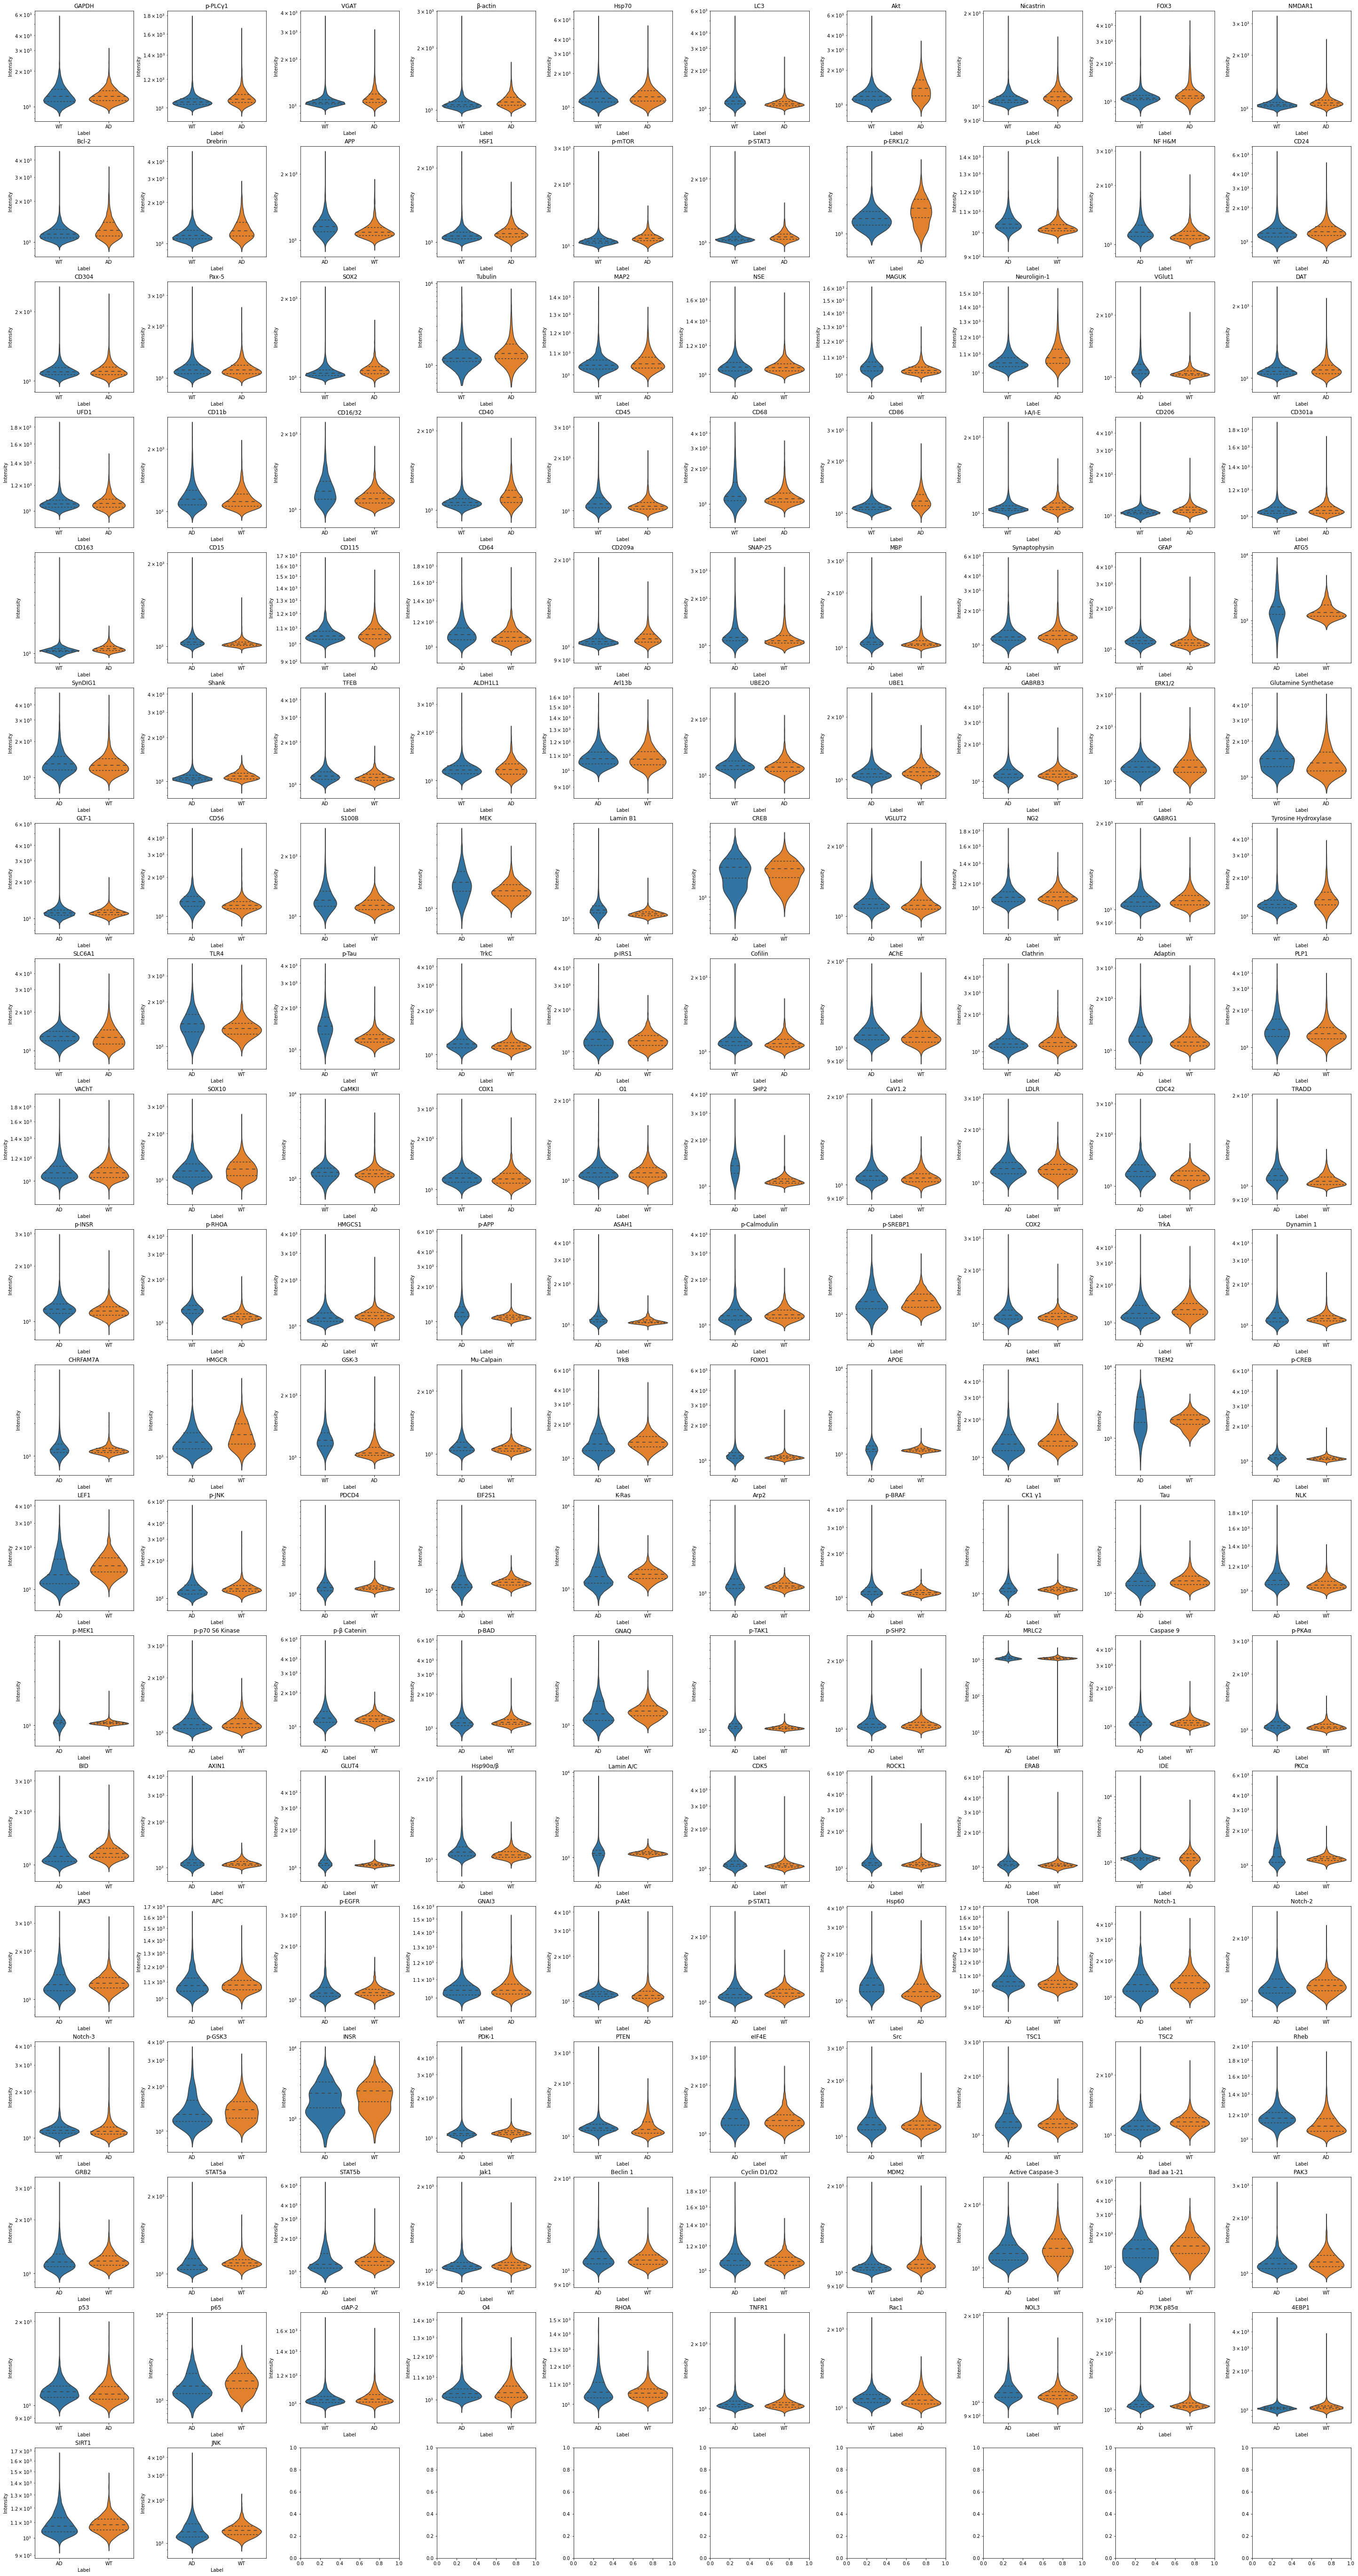

In [137]:
# Creating the plot figures for violin plot
ncols = 10
nrows = math.ceil((len(data.columns)-1)/ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, figsize=(ncols*4, nrows*4))
for i, axes in zip(range(len(data.columns)-1), axes.flatten()):
    axes.set_yscale("log")
    make_plot(data.iloc[:,i+1], data.iloc[:,0], bg, 3, 'violinplot')

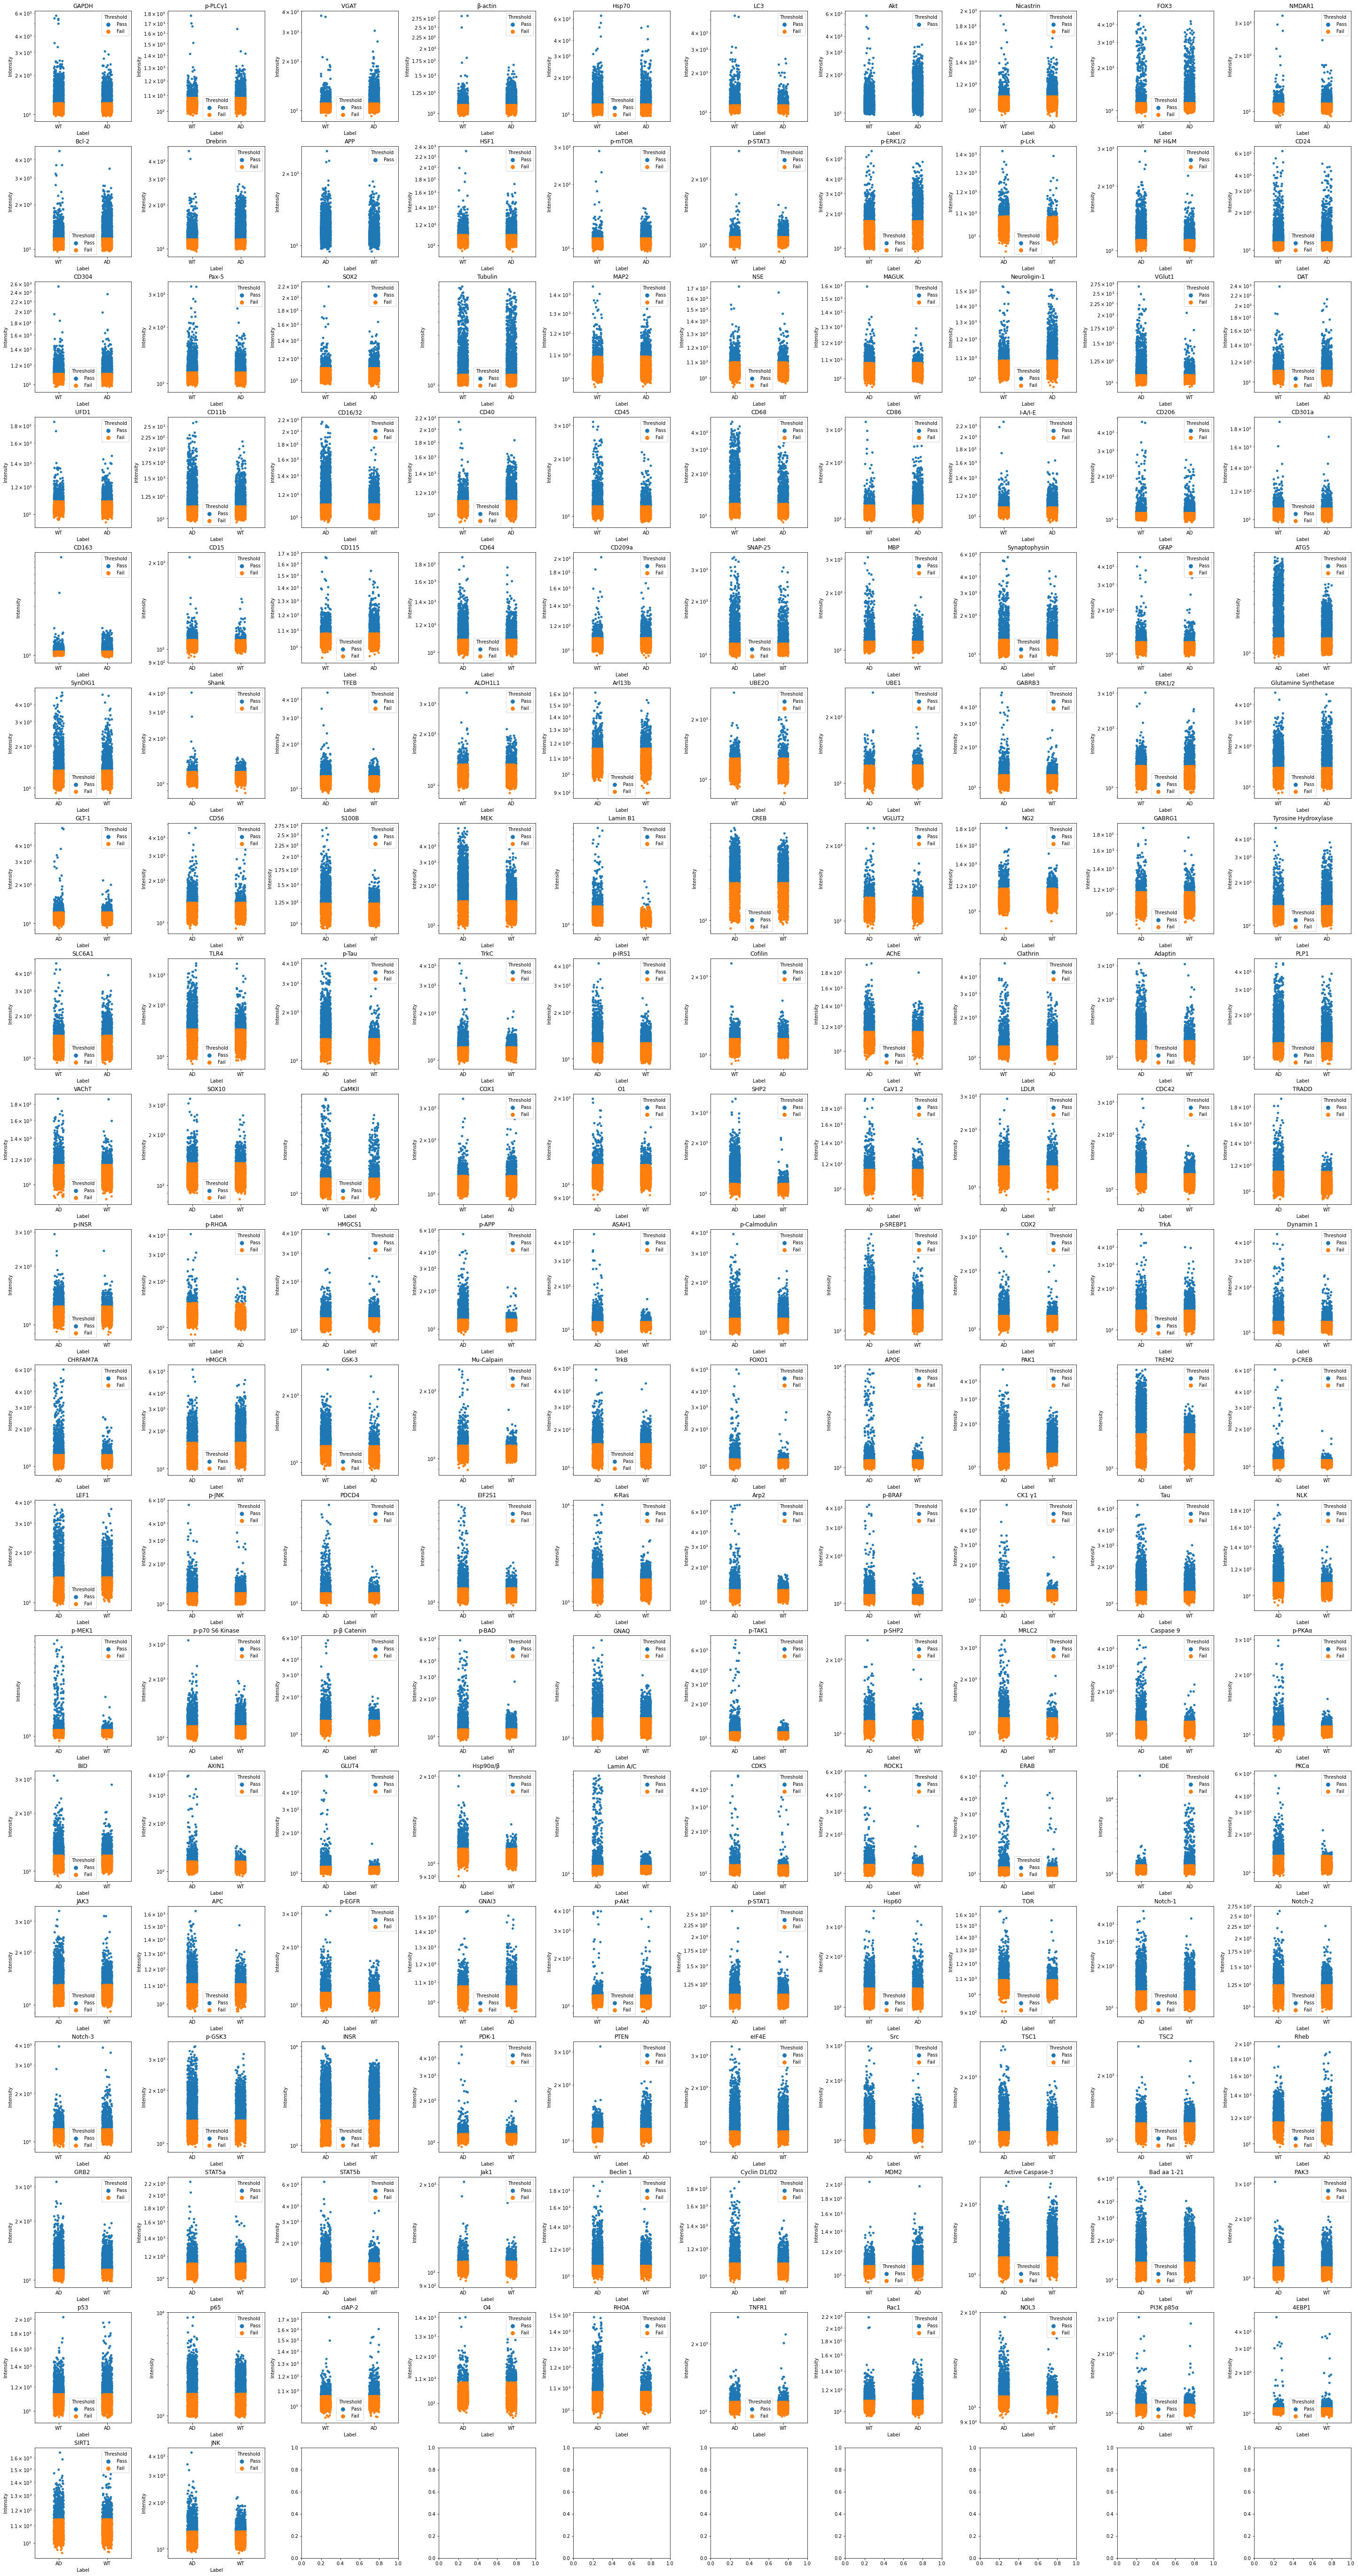

In [138]:
# Creating the plot figures for strip plot
ncols = 10
nrows = math.ceil((len(data.columns)-1)/ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, figsize=(ncols*4, nrows*4))
for i, axes in zip(range(len(data.columns)-1), axes.flatten()):
    axes.set_yscale("log")
    make_plot(data.iloc[:,i+1], data.iloc[:,0], bg, 3, 'stripplot')